## For Fraud Data

### Handle Missing Values


In [2]:
import pandas as pd 

fraud_df = pd.read_csv("../Data/raw/Fraud_Data.csv")

# Check missing
print(fraud_df.isnull().sum())

# Drop or impute (this assumes very few missing)
fraud_df = fraud_df.dropna()  # Or impute if necessary


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64


### Data Cleaning

In [4]:
# Drop duplicates
fraud_df = fraud_df.drop_duplicates()

# Fix data types
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


### Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Fraud vs Legitimate Class Distribution')

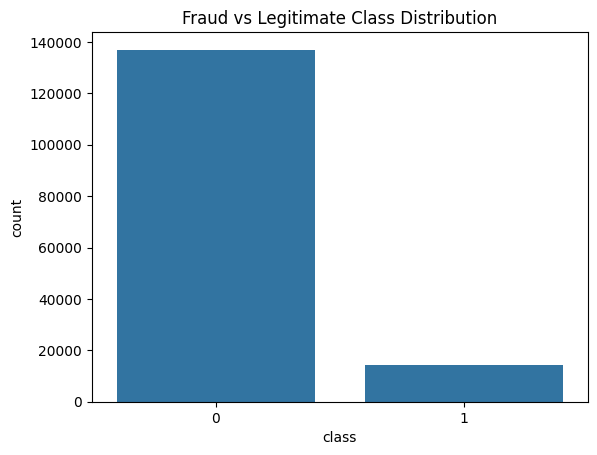

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# univariate analysis
sns.countplot(x='class', data=fraud_df)
plt.title('Fraud vs Legitimate Class Distribution')

  

Text(0.5, 1.0, 'Purchase Value by Class')

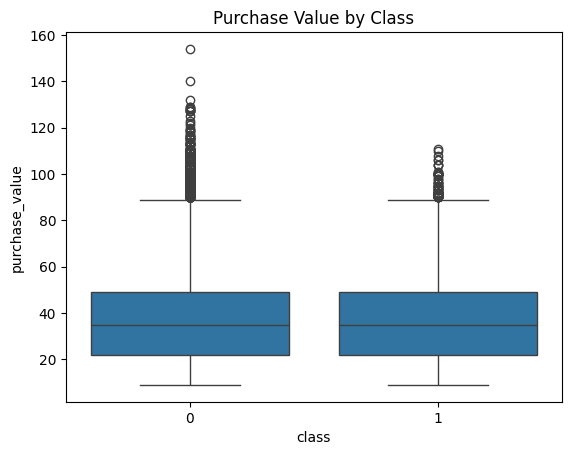

In [7]:
# Bivariate analysis
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title('Purchase Value by Class')  

###  Merge IP to Country

In [23]:
import pandas as pd

# Load your datasets
fraud_df = pd.read_csv("../Data/raw/Fraud_Data.csv")
ip_df = pd.read_csv("../Data/raw/IpAddress_to_Country.csv")

# Rename column for clarity
fraud_df = fraud_df.rename(columns={"ip_address": "ip_int"})

# Sort both DataFrames for merge_asof
fraud_df = fraud_df.sort_values("ip_int")
ip_df = ip_df.sort_values("lower_bound_ip_address")

# merge_asof finds the nearest lower_bound for each ip
merged_df = pd.merge_asof(
    fraud_df,
    ip_df,
    left_on="ip_int",
    right_on="lower_bound_ip_address",
    direction="backward"
)

# Keep only rows where ip_int is within the IP range
merged_df = merged_df[merged_df["ip_int"] <= merged_df["upper_bound_ip_address"]]

# Drop the IP range columns if you no longer need them
merged_df = merged_df.drop(columns=["lower_bound_ip_address", "upper_bound_ip_address"])

# Now you have fraud_df with a 'country' column
print(merged_df[['user_id', 'ip_int', 'country']].head())
merged_df.head()


     user_id        ip_int    country
634   247547  1.677886e+07  Australia
635   220737  1.684205e+07   Thailand
636   390400  1.684366e+07      China
637    69592  1.693873e+07      China
638   174987  1.697198e+07   Thailand


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_int,class,country
634,247547,2015-06-28 03:00:34,2015-08-09 03:57:29,47,KIXYSVCHIPQBR,SEO,Safari,F,30,1.677886e+07,0,Australia
635,220737,2015-01-28 14:21:11,2015-02-11 20:28:28,15,PKYOWQKWGJNJI,SEO,Chrome,F,34,1.684205e+07,0,Thailand
636,390400,2015-03-19 20:49:09,2015-04-11 23:41:23,44,LVCSXLISZHVUO,Ads,IE,M,29,1.684366e+07,0,China
637,69592,2015-02-24 06:11:57,2015-05-23 16:40:14,55,UHAUHNXXUADJE,Direct,Chrome,F,30,1.693873e+07,0,China
638,174987,2015-07-07 12:58:11,2015-11-03 04:04:30,51,XPGPMOHIDRMGE,SEO,Chrome,F,37,1.697198e+07,0,Thailand


###  Feature Engineering

In [27]:
import pandas as pd

# Ensure datetime columns are in datetime format
merged_df['signup_time'] = pd.to_datetime(merged_df['signup_time'])
merged_df['purchase_time'] = pd.to_datetime(merged_df['purchase_time'])

# Hour of day for purchase
merged_df['hour_of_day'] = merged_df['purchase_time'].dt.hour

# Day of week for purchase (Monday=0, Sunday=6)
merged_df['day_of_week'] = merged_df['purchase_time'].dt.dayofweek

# Time since signup (in hours)
merged_df['time_since_signup'] = (merged_df['purchase_time'] - merged_df['signup_time']).dt.total_seconds() / 3600

# Transaction frequency: count of transactions per user
merged_df['transaction_count'] = merged_df.groupby('user_id')['user_id'].transform('count')

# Transaction velocity: transactions per day per user
merged_df['days_active'] = (merged_df.groupby('user_id')['purchase_time'].transform('max') - 
                            merged_df.groupby('user_id')['purchase_time'].transform('min')).dt.days + 1
merged_df['transaction_velocity'] = merged_df['transaction_count'] / merged_df['days_active']

# Preview new features
print(merged_df[['user_id', 'hour_of_day', 'day_of_week', 'time_since_signup', 'transaction_count', 'transaction_velocity']].head(10))

     user_id  hour_of_day  day_of_week  time_since_signup  transaction_count  \
634   247547            3            6        1008.948611                  1   
635   220737           20            2         342.121389                  1   
636   390400           23            5         554.870556                  1   
637    69592           16            5        2122.471389                  1   
638   174987            4            1        2847.105278                  1   
639    23204            4            6        1134.798611                  1   
640   155230           13            3        1613.465000                  1   
641   199369           18            6        1371.587778                  1   
642   236894            1            5         933.447778                  1   
643   379446           22            4        2001.228611                  1   

     transaction_velocity  
634                   1.0  
635                   1.0  
636                   1.0  
637    

In [28]:
unique_velocities = merged_df['transaction_velocity'].unique()
print(unique_velocities)
print(f"Total unique values: {len(unique_velocities)}")

[1.]
Total unique values: 1


In [29]:
print(merged_df['transaction_count'].value_counts())
print(merged_df['days_active'].value_counts())

transaction_count
1    129146
Name: count, dtype: int64
days_active
1    129146
Name: count, dtype: int64


### Data Transformation

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# 1. Handle Class Imbalance
print(merged_df['class'].value_counts())  # Analyze class distribution

# Split features and target
X = merged_df.drop('class', axis=1)
y = merged_df['class']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Separate numerical and categorical columns
num_cols = X_train.select_dtypes(include=[float, int]).columns
cat_cols = ['browser', 'source', 'sex', 'country']

# Apply SMOTE to numerical features only
smote = SMOTE(random_state=42)
X_train_num_res, y_train_res = smote.fit_resample(X_train[num_cols], y_train)

# Find how many times each original row was used in the resampled set
from collections import Counter

# Get the counts of each original sample in the resampled set
sample_counts = Counter(smote._sampling_strategy[y_train.values.argmax()]) if hasattr(smote, '_sampling_strategy') else Counter()
if hasattr(X_train, 'index'):
    # If index is available, use it
    orig_indices = X_train.index
else:
    orig_indices = np.arange(len(X_train))

# Build categorical features for resampled set
cat_rows = []
for idx in smote.fit_resample(np.arange(len(X_train[num_cols])).reshape(-1, 1), y_train)[0].flatten():
    cat_rows.append(X_train.iloc[idx][cat_cols].values)
X_train_cat_res = np.array(cat_rows)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num_res)
X_test_scaled = scaler.transform(X_test[num_cols])

# Encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat_encoded = encoder.fit_transform(X_train_cat_res)
X_test_cat_encoded = encoder.transform(X_test[cat_cols])

# Stack numerical and categorical features
X_train_final = np.hstack([X_train_scaled, X_train_cat_encoded])
X_test_final = np.hstack([X_test_scaled, X_test_cat_encoded])

class
0    116878
1     12268
Name: count, dtype: int64


/home/feven-alemayehu/Documents/KAIM/week8and9/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
